In [9]:
import sys
sys.path.append(r'/Users/brendanliang/Code/brendans_bloomberg') 
import numpy as np
import pandas as pd
import os
import subprocess
import shlex
import matplotlib.pyplot as plt
from datetime import datetime
from tools.helper.pandas_tools import find_col_index
from interface.company import Company
from interface.indicator import Yahoo_Indicator
from interface.forex import forex

In [10]:
company = Company("VALE")

# Share Price History

In [11]:
start_date = datetime(2018,8,25).date()
company_index = np.where(company.price_history.dates == start_date)[0]
benchmark_index_index = np.where(Yahoo_Indicator("^GSPC").dates == start_date)[0]
plt.figure(figsize=(8, 4))  # Customize the figure size if needed
plt.plot(company.price_history.dates, company.price_history.close/float(company.price_history.close[company_index]))
plt.plot(Yahoo_Indicator("^GSPC").dates, Yahoo_Indicator("^GSPC").close/float(Yahoo_Indicator("^GSPC").close[benchmark_index_index]))
plt.xlabel("Date")
plt.ylabel("Return")
plt.title("Stock Price History")
plt.grid(True)
plt.xlim(start_date, datetime.today())
plt.legend([str(company.profile.name), "S&P Benchmark"])

# Financial Performance

## Income Statement

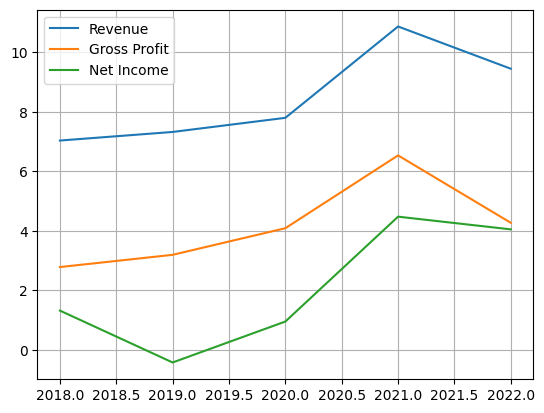

In [12]:
n = 5
fig, ax = plt.subplots()
year, revenue, gross_profit, net_income, shs_out = [], [], [], [], []
for i in range(n):
    year.append(company.annual_income_statement.income_statement[i]['calendarYear'])
    revenue.append(company.annual_income_statement.income_statement[i]['revenue'])
    gross_profit.append(company.annual_income_statement.income_statement[i]['grossProfit'])
    net_income.append(company.annual_income_statement.income_statement[i]['netIncome'])
    shs_out.append(company.annual_income_statement.income_statement[i]['weightedAverageShsOut'])
    
ax.plot(year, np.array(revenue)/np.array(shs_out), label = "Revenue")
ax.plot(year, np.array(gross_profit)/np.array(shs_out), label = "Gross Profit")
ax.plot(year, np.array(net_income)/np.array(shs_out), label = "Net Income")
ax.grid()
ax.legend()
plt.show()

## Cash Flows

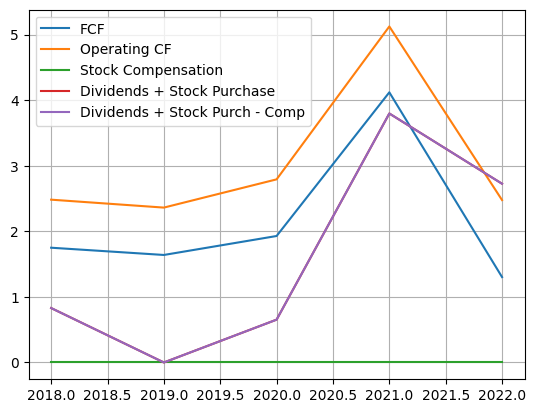

In [13]:
fig, ax = plt.subplots()
year, fcf, operating_cf, stock_comp, stock_repurchase, dividends = [], [], [], [], [], []
for i in range(n):
    year.append(company.annual_cashflow.cashflow[i]['calendarYear'])
    stock_comp.append(company.annual_cashflow.cashflow[i]['stockBasedCompensation'])
    stock_repurchase.append(company.annual_cashflow.cashflow[i]['commonStockRepurchased'])
    dividends.append(company.annual_cashflow.cashflow[i]['dividendsPaid'])
    operating_cf.append(company.annual_cashflow.cashflow[i]['operatingCashFlow'])
    fcf.append(company.annual_cashflow.cashflow[i]['freeCashFlow'])
    
ax.plot(year, np.array(fcf)/np.array(shs_out), label = "FCF")
ax.plot(year, np.array(operating_cf)/np.array(shs_out), label = "Operating CF")
ax.plot(year, np.array(stock_comp)/np.array(shs_out), label = "Stock Compensation")
ax.plot(year, (-np.array(dividends)-np.array(stock_repurchase))/np.array(shs_out), label = "Dividends + Stock Purchase")
ax.plot(year, (-np.array(stock_comp)-np.array(dividends)-np.array(stock_repurchase))/np.array(shs_out), label = "Dividends + Stock Purch - Comp")
ax.grid()
ax.legend()
plt.show()

## Balance Sheet

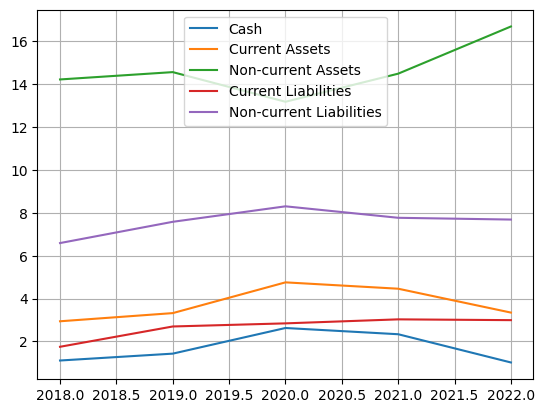

In [14]:
fig, ax = plt.subplots()
year, cashAndCashEquivalents, totalCurrentAssets, totalNonCurrenAssets, totalCurrentLiabilities, totalNonCurrentLiabilities = [], [], [], [], [], []
for i in range(n):
    year.append(company.annual_balance_sheet.balance_sheet[i]['calendarYear'])
    cashAndCashEquivalents.append(company.annual_balance_sheet.balance_sheet[i]['cashAndCashEquivalents'])
    totalCurrentAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentAssets'])
    totalNonCurrenAssets.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentAssets'])
    totalCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalCurrentLiabilities'])
    totalNonCurrentLiabilities.append(company.annual_balance_sheet.balance_sheet[i]['totalNonCurrentLiabilities'])
    
ax.plot(year, np.array(cashAndCashEquivalents)/np.array(shs_out), label = "Cash")
ax.plot(year, np.array(totalCurrentAssets)/np.array(shs_out), label = "Current Assets")
ax.plot(year, (np.array(totalNonCurrenAssets)-np.array(stock_repurchase))/np.array(shs_out), label = "Non-current Assets")
ax.plot(year, (np.array(totalCurrentLiabilities))/np.array(shs_out), label = "Current Liabilities")
ax.plot(year, (np.array(totalNonCurrentLiabilities))/np.array(shs_out), label = "Non-current Liabilities")
ax.grid()
ax.legend()
plt.show()

# Historical Valuations

[{'date': '2002-03-31', 'symbol': 'VALE', 'reportedCurrency': 'USD', 'cik': 917851, 'fillingDate': datetime.date(2002, 3, 31), 'acceptedDate': '2002-03-30 19:00:00', 'calendarYear': 2002, 'period': 'Q1', 'netIncome': 275000000.0, 'depreciationAndAmortization': 66000000.0, 'deferredIncomeTax': 12000000.0, 'stockBasedCompensation': 0.0, 'changeInWorkingCapital': -83000000.0, 'accountsReceivables': 0.0, 'inventory': 1000000.0, 'accountsPayables': 0.0, 'otherWorkingCapital': -84000000.0, 'otherNonCashItems': 45000000.0, 'netCashProvidedByOperatingActivities': 315000000.0, 'investmentsInPropertyPlantAndEquipment': -145000000.0, 'acquisitionsNet': 0.0, 'purchasesOfInvestments': -1000000.0, 'salesMaturitiesOfInvestments': 0.0, 'otherInvestingActivites': -29000000.0, 'netCashUsedForInvestingActivites': -175000000.0, 'debtRepayment': 0.0, 'commonStockIssued': 0.0, 'commonStockRepurchased': 0.0, 'dividendsPaid': 0.0, 'otherFinancingActivites': 750000000.0, 'netCashUsedProvidedByFinancingActiviti

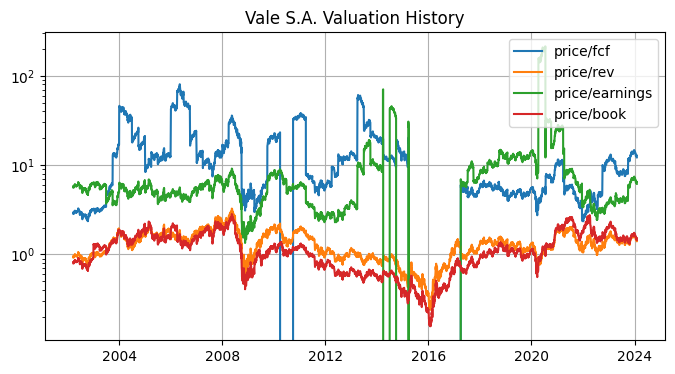

In [16]:
from matplotlib.pyplot import yscale
from interface.data_sources.price_history import price_history
from tools.TTM_calculator import trailing_twelve_month
from datetime import datetime
ttm_cashflow = trailing_twelve_month(company.symbol, "cashflow_statement")
ttm_balance_sheet = trailing_twelve_month(company.symbol, "balance_sheet")
ttm_income_statement = trailing_twelve_month(company.symbol, "income_statement")
dates = []
price_fcf = []
price_rev = []
price_earnings = []
price_book = []

for i in range(len(company.price_history.close)):
    date = company.price_history.dates[i]
    price = company.price_history.close[i]
    dates.append(date)
    for j in range(len(ttm_cashflow)-1):
        if date > ttm_cashflow[0]["fillingDate"]:
            index = 0
            break
        if  date < ttm_cashflow[j]["fillingDate"] and date > ttm_cashflow[j+1]["fillingDate"]:
            index  = j + 1
            break
        if date < ttm_cashflow[-1]["fillingDate"]:
            index = -1
            break
    price_fcf.append(price / (ttm_cashflow[index]["freeCashFlow"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_rev.append(price / (ttm_income_statement[index]["revenue"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_earnings.append(price / (ttm_income_statement[index]["netIncome"] / ttm_income_statement[index]["weightedAverageShsOut"]))
    price_book.append(price / ((ttm_balance_sheet[index]["totalAssets"] - ttm_balance_sheet[index]["totalLiabilities"]) / ttm_income_statement[index]["weightedAverageShsOut"]))

fig, ax = plt.subplots(figsize=(8, 4))
plt.yscale('log')
# plt.ylim(0, 100)
plt.title(f"{company.profile.name} Valuation History")
ax.plot(dates, price_fcf, label= "price/fcf")
ax.plot(dates, price_rev, label= "price/rev")
ax.plot(dates, price_earnings, label= "price/earnings")
ax.plot(dates, price_book, label= "price/book")
ax.grid()
ax.legend()